In [42]:
# import necessary libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller

In [ ]:
# Data retrieval
ticker_symbol = '^GSPC'  # S&P 500 Index
start_date = '2016-01-01'
end_date = '2025-05-31' # Or current date if you want the most recent data

data = yf.download(ticker_symbol, start=start_date, end=end_date)

# Preview the data
print(data.head())

/var/folders/xl/175qw0912j98h8914p56tcd00000gn/T/ipykernel_1351/3449947876.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker_symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

Price             Close         High          Low         Open      Volume
Ticker            ^GSPC        ^GSPC        ^GSPC        ^GSPC       ^GSPC
Date                                                                      
2016-01-04  2012.660034  2038.199951  1989.680054  2038.199951  4304880000
2016-01-05  2016.709961  2021.939941  2004.170044  2013.780029  3706620000
2016-01-06  1990.260010  2011.709961  1979.050049  2011.709961  4336660000
2016-01-07  1943.089966  1985.319946  1938.829956  1985.319946  5076590000
2016-01-08  1922.030029  1960.400024  1918.459961  1945.969971  4664940000


In [40]:
# Calculate daily logarithmic returns

# Choose the correct price column
price_col = 'Adj Close' if 'Adj Close' in data.columns else 'Close'

returns = np.log(data[price_col] / data[price_col].shift(1)).dropna()

# Display the first few returns
print("\n First few returns:")
print(returns.head())


 First few returns:
Ticker         ^GSPC
Date                
2016-01-05  0.002010
2016-01-06 -0.013202
2016-01-07 -0.023986
2016-01-08 -0.010898
2016-01-11  0.000853


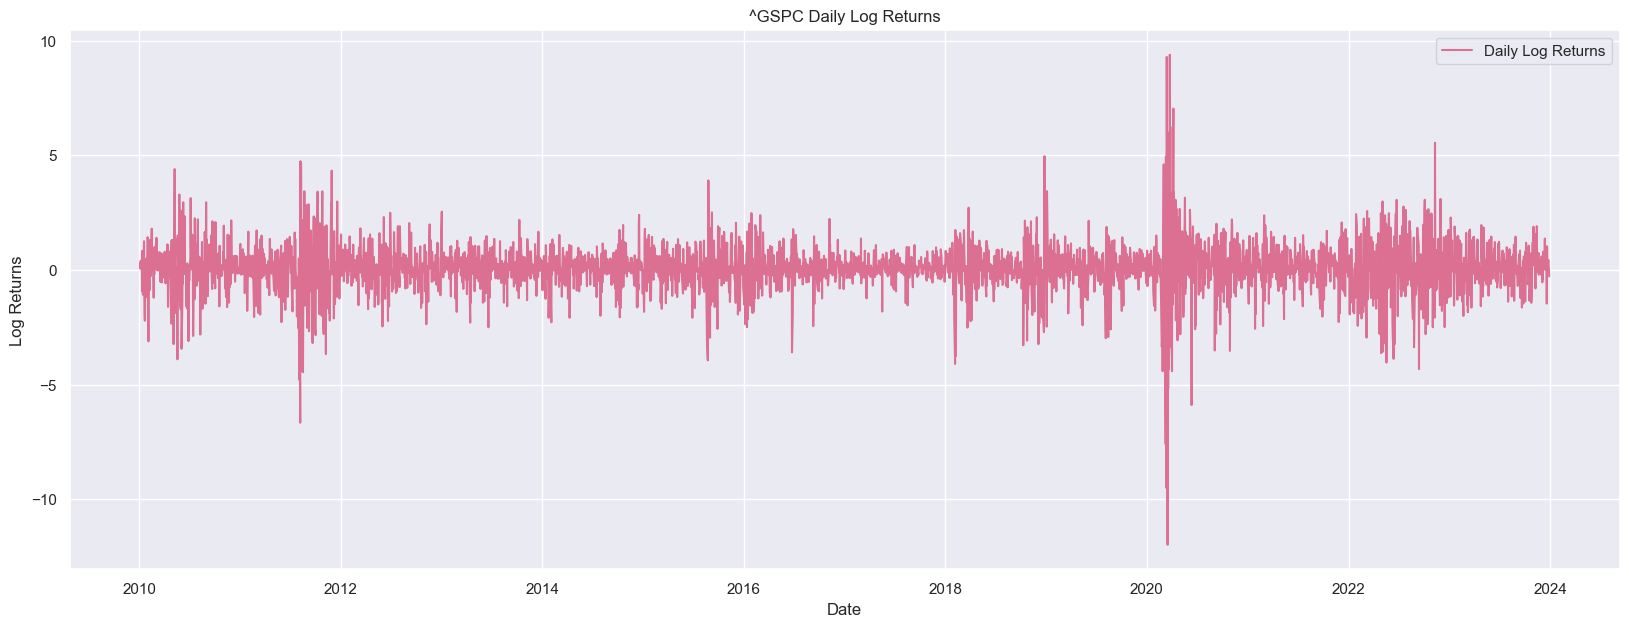

In [39]:
# Plot the returns to observe volatility clustering
plt.figure(figsize=(20, 7))
plt.plot(returns.index, returns,color = "palevioletred", label='Daily Log Returns')
plt.title(f'{ticker_symbol} Daily Log Returns')
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.grid(True)
plt.legend()
plt.show()

In [43]:
# Optional: Check for stationarity (e.g., using Augmented Dickey-Fuller test)

adf_result = adfuller(returns)
print(f'ADF Statistic: {adf_result}')
print(f'P-value: {adf_result[5]}')
# (A low p-value indicates stationarity, which is generally expected for log returns)

ADF Statistic: (np.float64(-15.501836862462824), np.float64(2.410073622861824e-28), 8, 2356, {'1%': np.float64(-3.433128624404979), '5%': np.float64(-2.8627675485259805), '10%': np.float64(-2.5674234771965376)}, np.float64(-14327.675405444457))
P-value: -14327.675405444457


In [45]:
# Define a rolling window size (e.g., 20 days for approximate monthly volatility)
window_size = 20

# Calculate rolling standard deviation and annualize it
# Annualization factor is sqrt(252) for daily returns
rolling_std = returns.rolling(window=window_size).std() * np.sqrt(252) 

# Display the first few rolling standard deviations 
print("\nFirst few rolling standard deviations (annualized):")
print(rolling_std.head())


First few rolling standard deviations (annualized):
Ticker      ^GSPC
Date             
2016-01-05    NaN
2016-01-06    NaN
2016-01-07    NaN
2016-01-08    NaN
2016-01-11    NaN


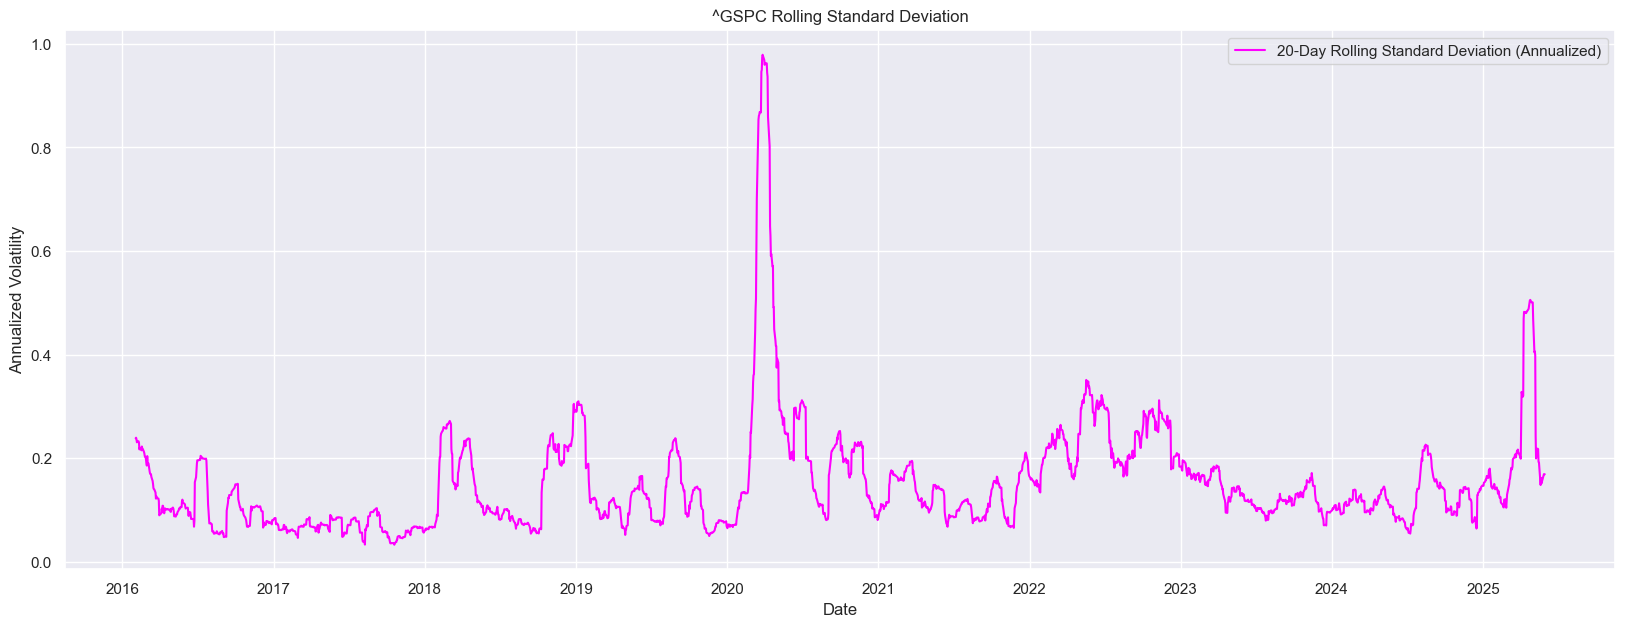

In [46]:
# Plot rolling standard deviation
plt.figure(figsize=(20, 7))
plt.plot(rolling_std.index, rolling_std, label=f'{window_size}-Day Rolling Standard Deviation (Annualized)', color='magenta')
plt.title(f'{ticker_symbol} Rolling Standard Deviation')
plt.xlabel('Date')
plt.ylabel('Annualized Volatility')
plt.grid(True)
plt.legend()
plt.show()


GARCH(1,1) Model Summary:
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  ^GSPC   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                5872.56
Distribution:                  Normal   AIC:                          -11737.1
Method:            Maximum Likelihood   BIC:                          -11714.0
                                        No. Observations:                 2365
Date:                Tue, Jun 24 2025   Df Residuals:                     2364
Time:                        15:46:43   Df Model:                            1
                                  Mean Model                                  
                 coef    std err          t      P>|t|        95.0% Conf. Int.
------------------------------------------------------------------------------
mu            -0.0160  4.

/opt/anaconda3/envs/yaman/lib/python3.13/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001364. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


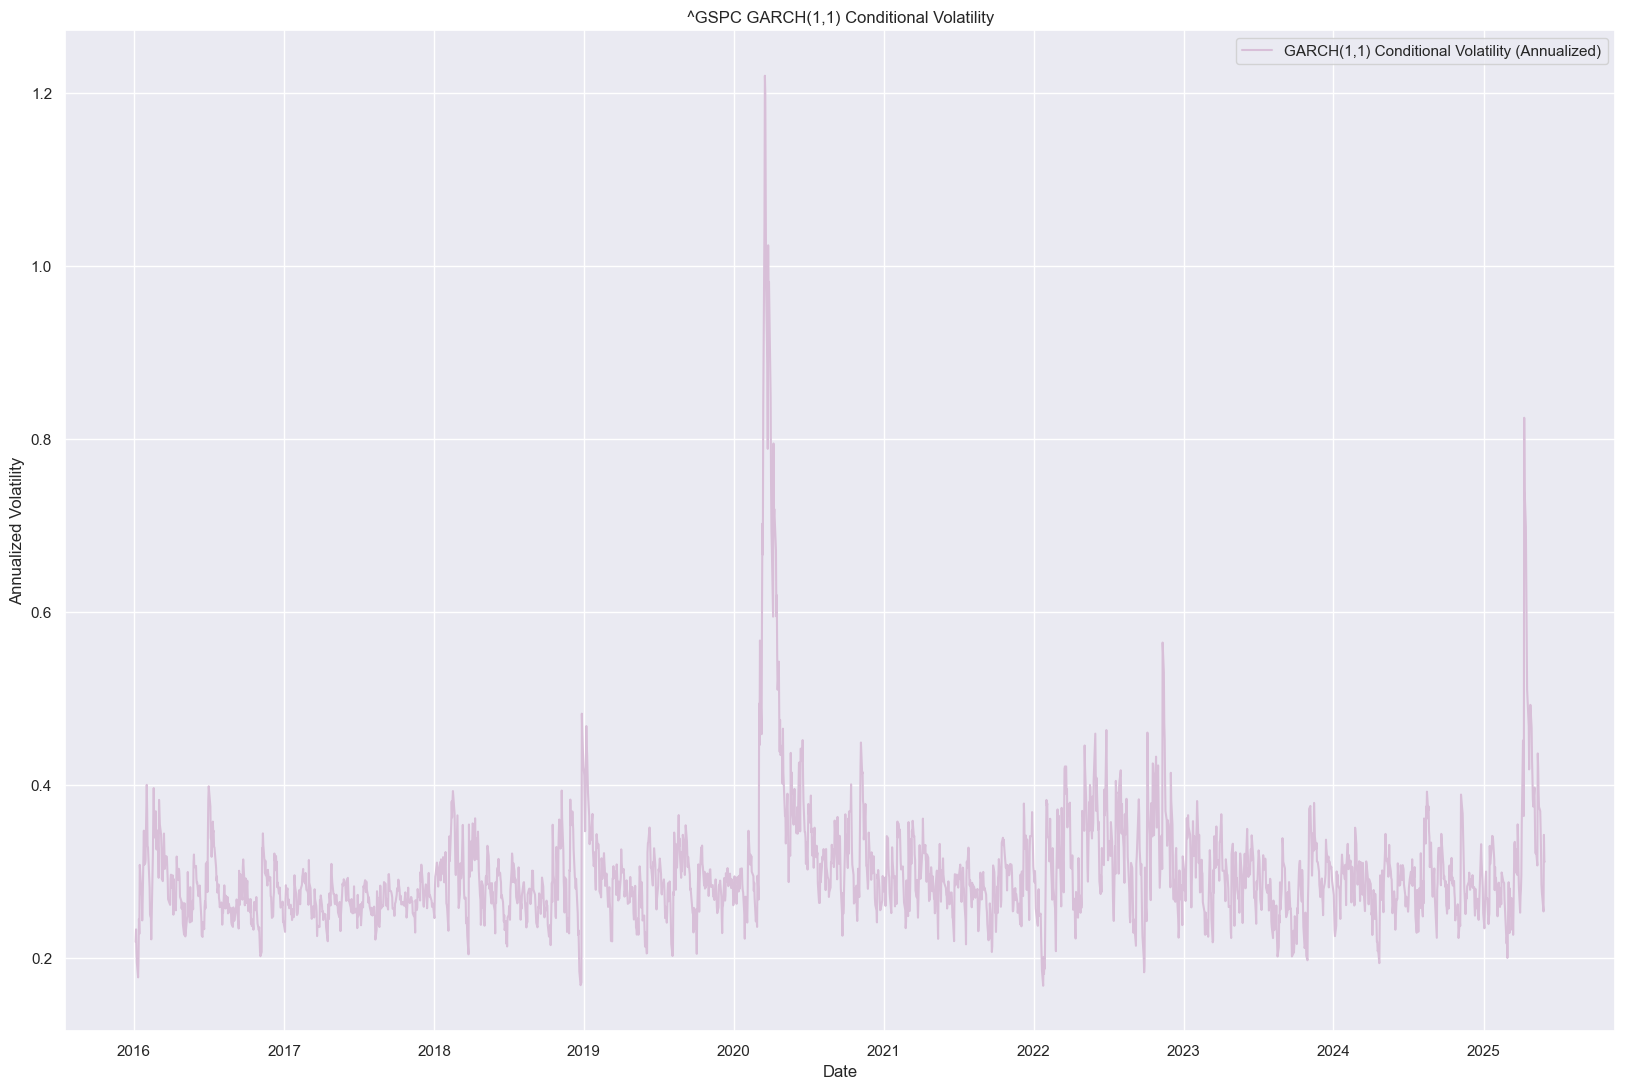

In [52]:
'''  
The mean return of the S&P 500 is statistically significant but very close to zero over the period.
The volatility of the S&P 500 returns is not constant but exhibits volatility clustering, meaning periods of high (low) volatility are followed by periods of high (low)
volatility. This is evidenced by the highly significant alpha[1] and beta[1] coefficients.
Both past unexpected market movements (alpha[1]) and past volatility (beta[1]) significantly influence current volatility.
The sum of alpha[1] and beta[1] being 0.98 indicates very persistent volatility.
'''

# Specify the GARCH(1,1) model
# mean='Constant' assumes a constant mean for returns
# vol='Garch' specifies the GARCH volatility model
# p=1, q=1 for GARCH(1,1)
# dist='normal' for Gaussian errors, 'skewt' or 't' for fat tails (more realistic for financial data)
garch_model = arch_model(returns, mean='Constant', vol='Garch', p=1, q=1, dist='normal')

# Fit the model
# update_freq=10 prints progress every 10 iterations
garch_results = garch_model.fit(disp='off') # disp='off' to suppress iteration output

# Print the model summary
print("\nGARCH(1,1) Model Summary:")
print(garch_results.summary())

# Extract conditional volatility from the fitted model
garch_conditional_volatility = garch_results.conditional_volatility * np.sqrt(252) # Annualize

# Plot conditional volatility
plt.figure(figsize=(20, 13))
plt.plot(garch_conditional_volatility.index, garch_conditional_volatility, label='GARCH(1,1) Conditional Volatility (Annualized)', color='thistle')
plt.title(f'{ticker_symbol} GARCH(1,1) Conditional Volatility')
plt.xlabel('Date')
plt.ylabel('Annualized Volatility')
plt.grid(True)
plt.legend()
plt.show()


GARCH(1,1) Model Summary (with Student's t-distribution):
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  ^GSPC   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                5872.56
Distribution:                  Normal   AIC:                          -11737.1
Method:            Maximum Likelihood   BIC:                          -11714.0
                                        No. Observations:                 2365
Date:                Tue, Jun 24 2025   Df Residuals:                     2364
Time:                        15:46:16   Df Model:                            1
                                  Mean Model                                  
                 coef    std err          t      P>|t|        95.0% Conf. Int.
------------------------------------------------------------------------

/opt/anaconda3/envs/yaman/lib/python3.13/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001364. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


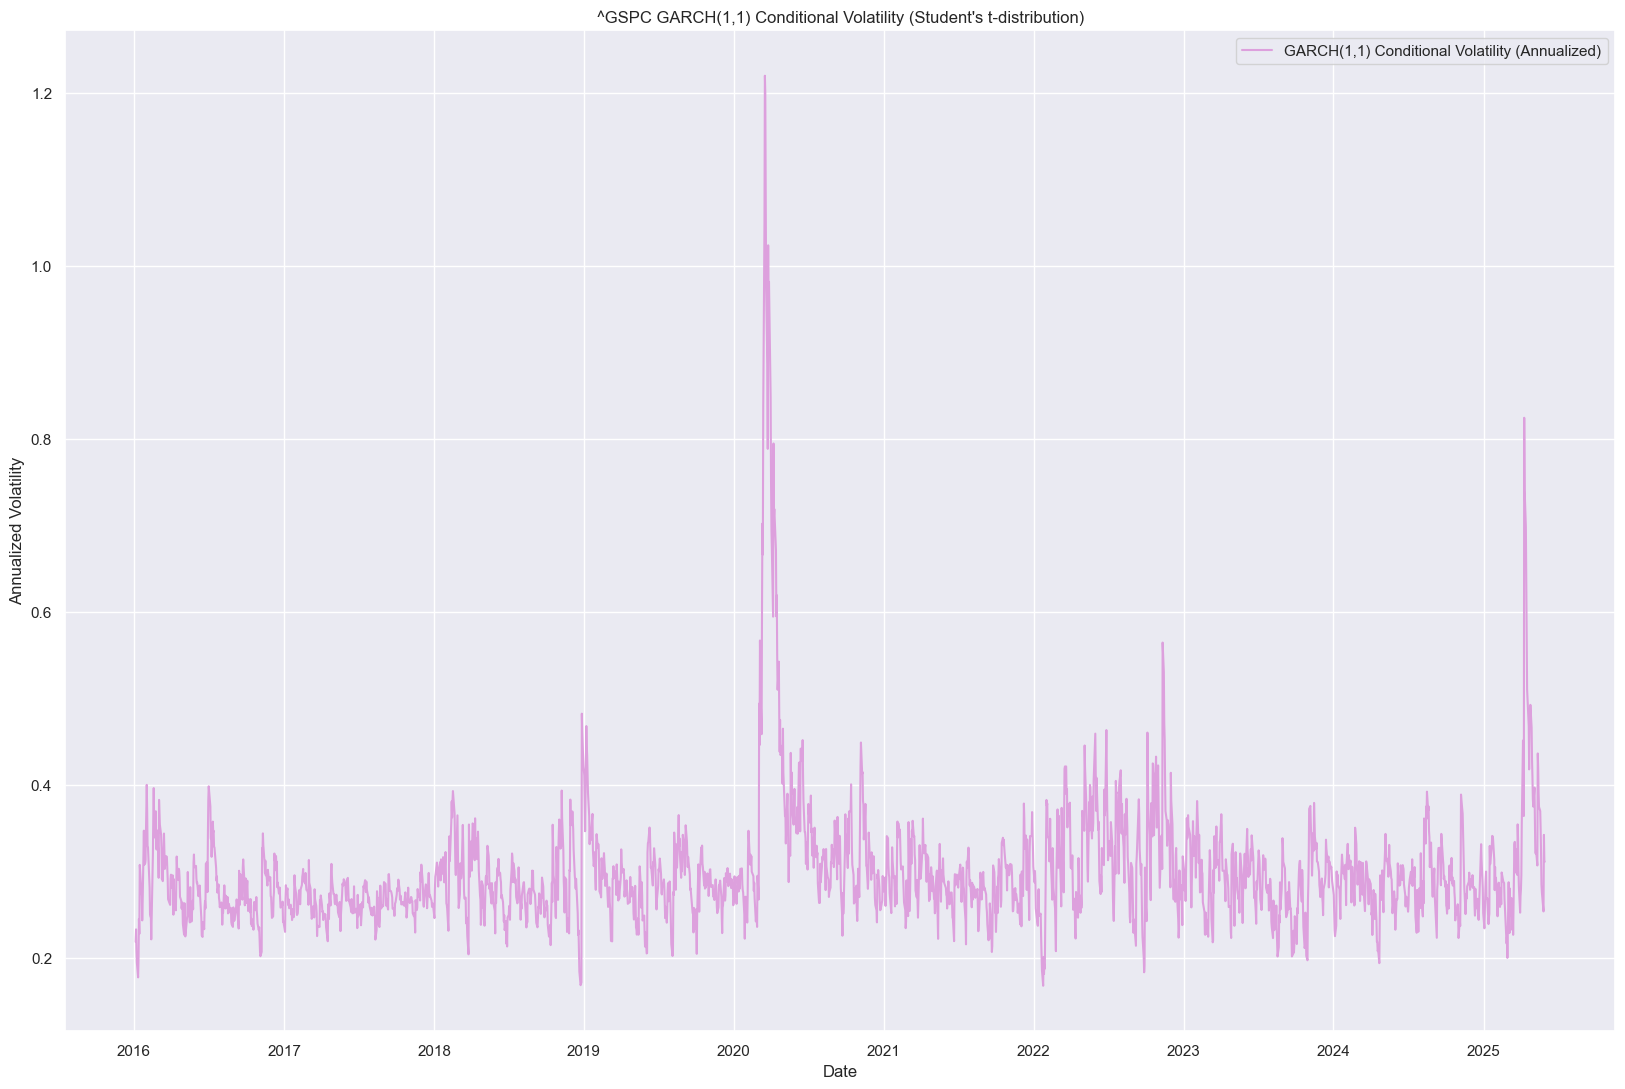

In [50]:
import numpy as np
import pandas as pd
from arch import arch_model
import matplotlib.pyplot as plt

# Assuming 'returns' and 'ticker_symbol' are already defined
# For demonstration purposes, let's create some dummy data:
# np.random.seed(42)
# dummy_returns = np.random.normal(loc=0.0005, scale=0.01, size=1000)
# returns = pd.Series(dummy_returns, index=pd.date_range(start='2018-01-01', periods=1000, freq='B'))
# ticker_symbol = "DUMMY_STOCK"

# Specify the GARCH(1,1) model with 't' distribution
# mean='Constant' assumes a constant mean for returns
# vol='Garch' specifies the GARCH volatility model
# p=1, q=1 for GARCH(1,1)
# dist='t' for Student's t-distribution, which accounts for fat tails
garch_model = arch_model(returns, mean='Constant', vol='Garch', p=1, q=1, dist='normal')

# Fit the model
# disp='off' to suppress iteration output
garch_results = garch_model.fit(disp='off')

# Print the model summary
print("\nGARCH(1,1) Model Summary (with Student's t-distribution):")
print(garch_results.summary())

# Extract conditional volatility from the fitted model
garch_conditional_volatility = garch_results.conditional_volatility * np.sqrt(252) # Annualize

# Plot conditional volatility
plt.figure(figsize=(20, 13))
plt.plot(garch_conditional_volatility.index, garch_conditional_volatility, label='GARCH(1,1) Conditional Volatility (Annualized)', color='plum')
plt.title(f'{ticker_symbol} GARCH(1,1) Conditional Volatility (Student\'s t-distribution)')
plt.xlabel('Date')
plt.ylabel('Annualized Volatility')
plt.grid(True)
plt.legend()
plt.show()

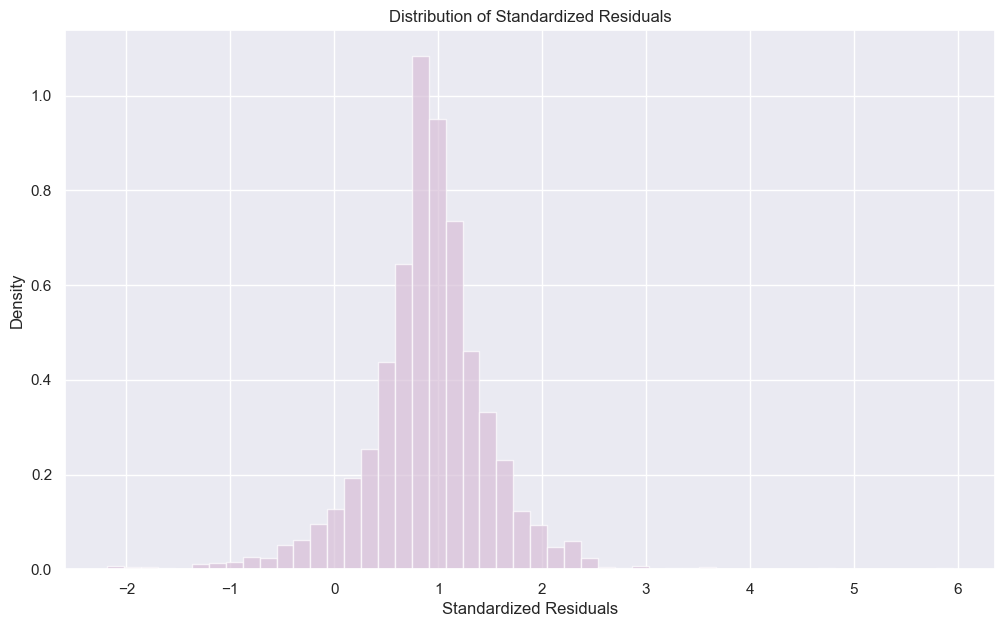

<Figure size 2000x1000 with 0 Axes>

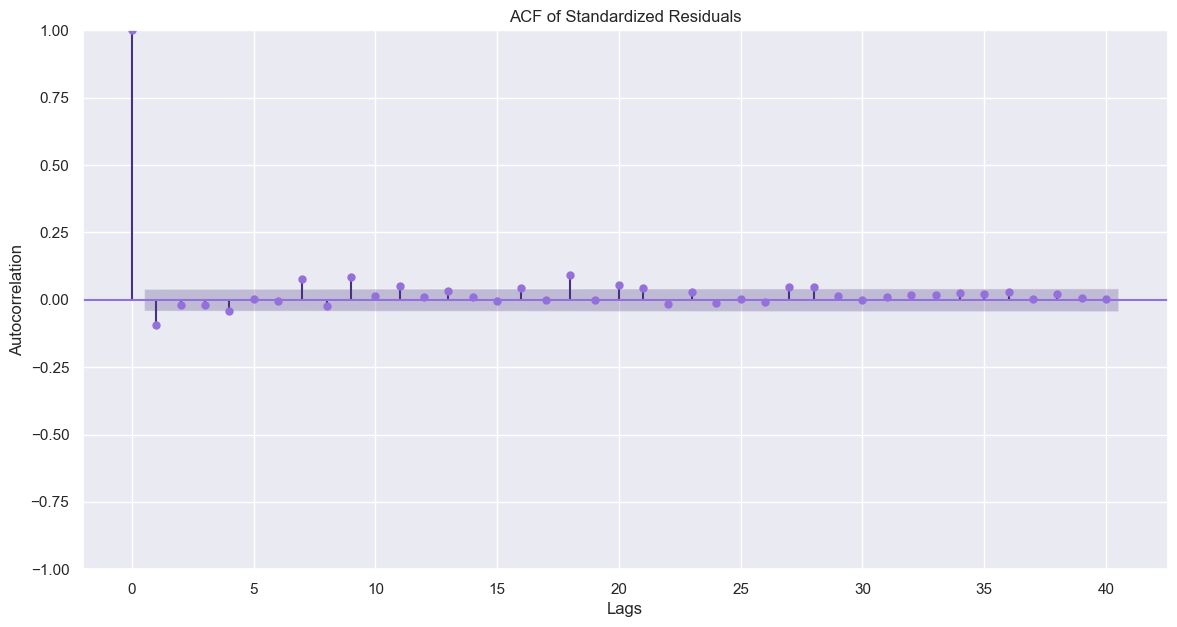

<Figure size 2000x1000 with 0 Axes>

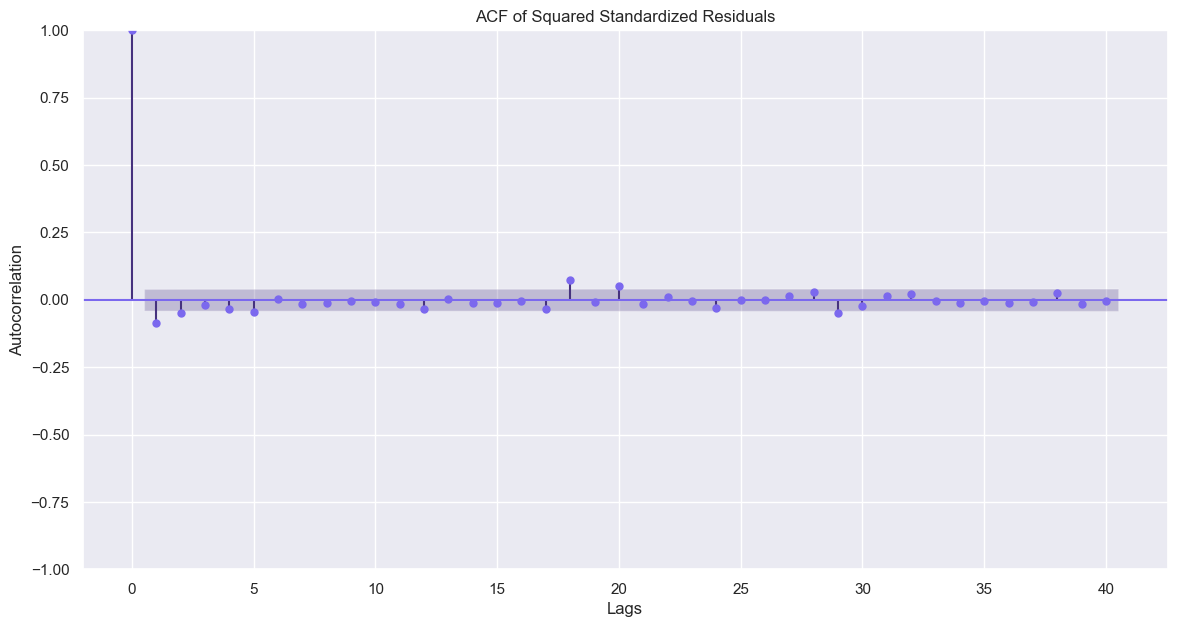

In [53]:
# Get standardized residuals
standardized_residuals = garch_results.resid / garch_results.conditional_volatility

# Plot distribution of standardized residuals
plt.figure(figsize=(12, 7))
plt.hist(standardized_residuals, bins=50, density=True, alpha=0.7, color='thistle')
plt.title('Distribution of Standardized Residuals')
plt.xlabel('Standardized Residuals')
plt.ylabel('Density')
plt.grid(True)
plt.show()

# Plot ACF of standardized residuals
plt.figure(figsize=(20, 10))
plot_acf(standardized_residuals, lags=40, alpha=0.05 , color = 'mediumpurple')
plt.title('ACF of Standardized Residuals')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.show()

# Plot ACF of squared standardized residuals (to check for remaining ARCH effects)
plt.figure(figsize=(20, 10))
plot_acf(standardized_residuals**2, lags=40, alpha=0.05, color = 'mediumslateblue')
plt.title('ACF of Squared Standardized Residuals')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.show()

In [54]:
# Ljung-Box test on standardized residuals
# H0: The data is independently distributed (white noise)
# If p-value < 0.05, reject H0, indicating remaining autocorrelation

lb_test_residuals = acorr_ljungbox(standardized_residuals, lags=[1, 13], return_df=True)
print("\nLjung-Box Test on Standardized Residuals:")
print(lb_test_residuals)

# Ljung-Box test on squared standardized residuals
lb_test_squared_residuals = acorr_ljungbox(standardized_residuals**2, lags=[1, 13], return_df=True)
print("\nLjung-Box Test on Squared Standardized Residuals:")
print(lb_test_squared_residuals)

# Interpretation: the given p-values are high (e.g., > 0.05), it suggests the model has adequately captured the conditional heteroskedasticity.


Ljung-Box Test on Standardized Residuals:
      lb_stat     lb_pvalue
1   20.602436  5.652415e-06
13  69.076151  1.186958e-09

Ljung-Box Test on Squared Standardized Residuals:
      lb_stat  lb_pvalue
1   17.278624   0.000032
13  36.127976   0.000567


In [30]:
# Define the size of the training window for rolling forecasts
# A common choice is 250 days (approx. 1 year of trading days)
train_window_size = 250

# Initialize lists to store forecasts and realized volatility
garch_forecasts = []
realized_volatility_proxy = []
# Using squared returns as a simple proxy for daily realized volatility

# Loop through the returns data to perform rolling forecasts
# Start forecasting after the initial training window
for i in range(train_window_size, len(returns)):
    # Define the training data window
    train_data = returns.iloc[i - train_window_size:i]

    # Fit GARCH(1,1) model to the training data
    # disp='off' to suppress output for each fit
    model = arch_model(train_data, mean='Constant', vol='Garch', p=1, q=1, dist='normal')
    res = model.fit(disp='off')

    # Make a one-step-ahead forecast
    # forecast() returns a DataFrame with 'h.1' column for 1-step ahead variance
    forecast = res.forecast(horizon=1)
    garch_next_period_variance = forecast.variance.iloc[-1, 0] # Get the first forecast (h.1)

    # Store the forecasted volatility (square root of variance)
    garch_forecasts.append(np.sqrt(garch_next_period_variance) * np.sqrt(252)) # Annualize

    # Store the actual realized volatility for the next period (squared return)
    # For simplicity, we use the squared return of the next day as a proxy for realized volatility
    # In practice, realized volatility is often calculated from intraday data [16, 17]
    realized_volatility_proxy.append(np.abs(returns.iloc[i]) * np.sqrt(252)) # Annualize absolute returns as proxy

# Create a DataFrame for forecasts and realized volatility
forecast_index = returns.index[train_window_size:]
garch_forecast_series = pd.Series(garch_forecasts, index=forecast_index)
realized_vol_series = pd.Series(realized_volatility_proxy, index=forecast_index)

print("\nRolling GARCH Forecasts (first 5):")
print(garch_forecast_series.head())
print("\nRealized Volatility Proxy (first 5):")
print(realized_vol_series.head())

/opt/anaconda3/envs/yaman/lib/python3.13/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 6.739e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/opt/anaconda3/envs/yaman/lib/python3.13/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 6.749e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/opt/anaconda3/envs/yaman/lib/python3.13/site-packag


Rolling GARCH Forecasts (first 5):
Date
2016-12-30    0.094776
2017-01-03    0.097672
2017-01-04    0.106759
2017-01-05    0.104114
2017-01-06    0.096189
dtype: float64

Realized Volatility Proxy (first 5):
Date
2016-12-30    Ticker
^GSPC    0.073782
Name: 2016-12-30 00:0...
2017-01-03    Ticker
^GSPC    0.134152
Name: 2017-01-03 00:0...
2017-01-04    Ticker
^GSPC    0.090579
Name: 2017-01-04 00:0...
2017-01-05    Ticker
^GSPC    0.012239
Name: 2017-01-05 00:0...
2017-01-06    Ticker
^GSPC    0.055732
Name: 2017-01-06 00:0...
dtype: object


/opt/anaconda3/envs/yaman/lib/python3.13/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001019. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/opt/anaconda3/envs/yaman/lib/python3.13/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001019. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/opt/anaconda3/envs/yaman/lib/python3.13/site-packag

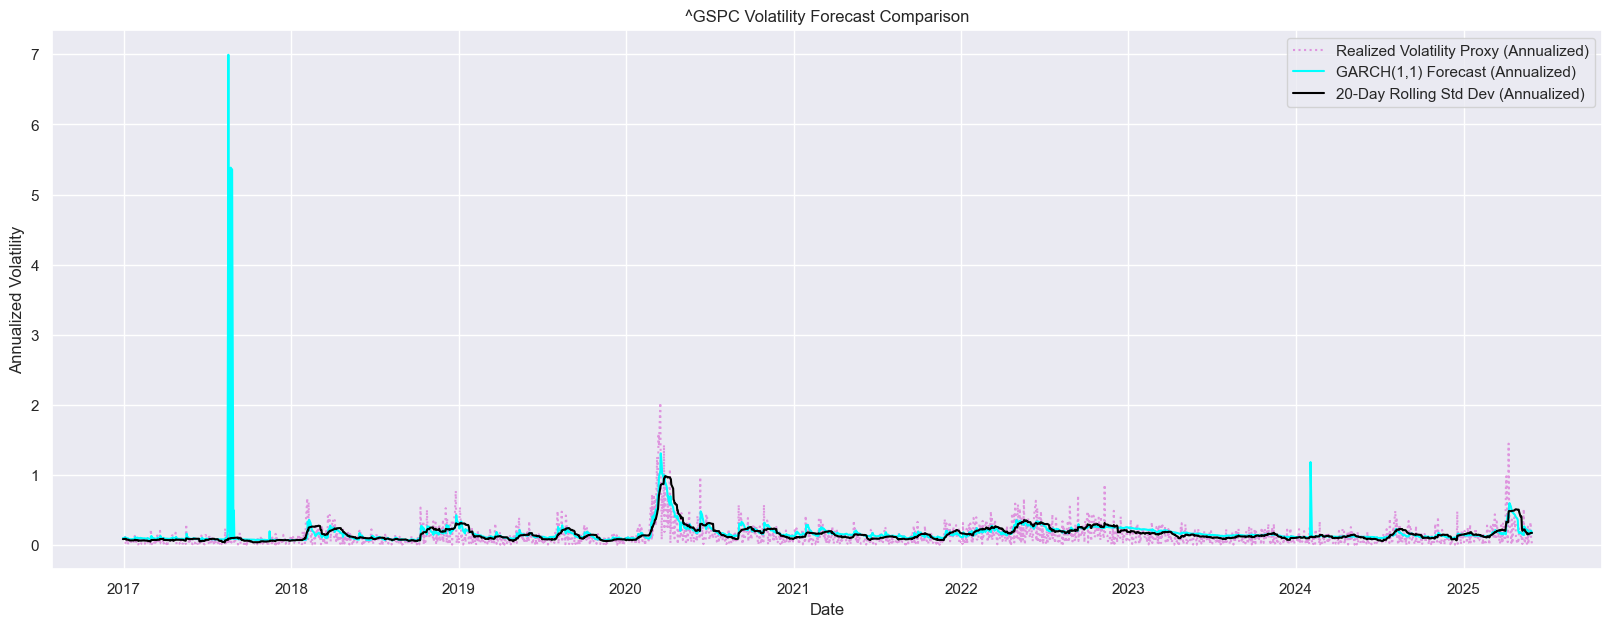


--- GARCH(1,1) Forecast Performance ---
Mean Absolute Error (MAE): 0.103000
Mean Squared Error (MSE): 0.069568
Root Mean Squared Error (RMSE): 0.263758
Correlation (Forecast vs. Realized): 0.2305

--- Rolling Standard Deviation Forecast Performance ---
Mean Absolute Error (MAE): 0.089855
Mean Squared Error (MSE): 0.017252
Root Mean Squared Error (RMSE): 0.131346
Correlation (Forecast vs. Realized): 0.5470

--- Comparative Performance Summary ---
| Model | MAE | MSE | RMSE | Correlation |
|--------------------------|----------|----------|----------|-------------|
| GARCH(1,1) | 0.103000 | 0.069568 | 0.263758 | 0.2305 |
| Rolling Standard Deviation | 0.089855 | 0.017252 | 0.131346 | 0.5470 |


In [77]:
# The main issue is that realized_vol_series contains elements that are pandas Series (with Ticker as index),
# so when creating the DataFrame, the 'realized' column becomes a column of objects (Series), not floats.
# We need to flatten realized_vol_series so each value is a float, not a Series.

# Convert realized_vol_series to a float Series (extract the value for each date)
def flatten_realized_vol(series):
    # If each element is a pandas Series, extract the first value
    return series.apply(lambda x: x.iloc[0] if hasattr(x, 'iloc') else x)

realized_vol_flat = flatten_realized_vol(realized_vol_series)

# Now align all series to the same index and length
combined_df = pd.DataFrame({
    'realized': realized_vol_flat,
    'garch_forecast': garch_forecast_series,
    'rolling_std': rolling_std.loc[garch_forecast_series.index].squeeze()  # Ensure rolling_std is a Series
}).dropna()

# Extract the aligned series
realized_vol_series_aligned = combined_df['realized']
garch_forecast_series_aligned = combined_df['garch_forecast']
rolling_std_aligned = combined_df['rolling_std']

# Check if the aligned series are empty before proceeding
if realized_vol_series_aligned.empty:
    print("Error: No common data points for comparison after alignment and NaN removal. Please check your data range and window sizes.")
else:
    # Plotting Forecasted vs. Realized Volatility
    plt.figure(figsize=(20, 7))
    plt.plot(realized_vol_series_aligned.index, realized_vol_series_aligned, label='Realized Volatility Proxy (Annualized)', color='orchid', linestyle = 'dotted', alpha=0.7)
    plt.plot(garch_forecast_series_aligned.index, garch_forecast_series_aligned, label='GARCH(1,1) Forecast (Annualized)', color='aqua')
    plt.plot(rolling_std_aligned.index, rolling_std_aligned, label=f'{window_size}-Day Rolling Std Dev (Annualized)', color='black')
    plt.title(f'{ticker_symbol} Volatility Forecast Comparison')
    plt.xlabel('Date')
    plt.ylabel('Annualized Volatility')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Statistical Metrics for GARCH(1,1)
    garch_mae = mean_absolute_error(realized_vol_series_aligned, garch_forecast_series_aligned)
    garch_mse = mean_squared_error(realized_vol_series_aligned, garch_forecast_series_aligned)
    garch_rmse = np.sqrt(garch_mse)
    garch_correlation = garch_forecast_series_aligned.corr(realized_vol_series_aligned)

    print("\n--- GARCH(1,1) Forecast Performance ---")
    print(f"Mean Absolute Error (MAE): {garch_mae:.6f}")
    print(f"Mean Squared Error (MSE): {garch_mse:.6f}")
    print(f"Root Mean Squared Error (RMSE): {garch_rmse:.6f}")
    print(f"Correlation (Forecast vs. Realized): {garch_correlation:.4f}")

    # Statistical Metrics for Rolling Standard Deviation
    rolling_std_mae = mean_absolute_error(realized_vol_series_aligned, rolling_std_aligned)
    rolling_std_mse = mean_squared_error(realized_vol_series_aligned, rolling_std_aligned)
    rolling_std_rmse = np.sqrt(rolling_std_mse)
    rolling_std_correlation = rolling_std_aligned.corr(realized_vol_series_aligned)

    print("\n--- Rolling Standard Deviation Forecast Performance ---")
    print(f"Mean Absolute Error (MAE): {rolling_std_mae:.6f}")
    print(f"Mean Squared Error (MSE): {rolling_std_mse:.6f}")
    print(f"Root Mean Squared Error (RMSE): {rolling_std_rmse:.6f}")
    print(f"Correlation (Forecast vs. Realized): {rolling_std_correlation:.4f}")

    # Summary Comparison Table
    print("\n--- Comparative Performance Summary ---")
    print("| Model | MAE | MSE | RMSE | Correlation |")
    print("|--------------------------|----------|----------|----------|-------------|")
    print(f"| GARCH(1,1) | {garch_mae:.6f} | {garch_mse:.6f} | {garch_rmse:.6f} | {garch_correlation:.4f} |")
    print(f"| Rolling Standard Deviation | {rolling_std_mae:.6f} | {rolling_std_mse:.6f} | {rolling_std_rmse:.6f} | {rolling_std_correlation:.4f} |")